# make-more : part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [ ]:
# building vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

In [ ]:
#build dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size  # initialize with "..."
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# split dataset
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [5]:
#MLP revised
n_emb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator= g)  # embedding matrix
W1 = torch.randn((n_emb * block_size, n_hidden), generator= g) * 0.2   # (10 * 3, 200)
b1 = torch.randn(n_hidden, generator= g) * 0.0  # this will subtract during batchnorm so no use of it
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01    # (200, 27)
b2 =  torch.randn(vocab_size, generator= g) * 0.0

# batch normalization
bngain = torch.ones(size=(1, n_hidden)) # parameters
bnbias = torch.zeros(size=(1, n_hidden)) # this bn bias is incharge of bias
bnmean_run = torch.zeros((1, n_hidden)) # buffers
bnstd_run = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [6]:
# same optimize as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini batch construct
  ix = torch.randint(low= 0, high= Xtr.shape[0], size = (batch_size,), generator= g) # return a tensor of randm (32,)
  Xb, Yb = Xtr[ix], Ytr[ix] # returns rows ids (ix) from Xtr (batch_size:32, block_size:3)

  # forward pass
  emb = C[Xb]  # embed the chars into vectors # (bacth_size:32, block_size:3, n_emb=10)
  embcat = emb.view((emb.shape[0], -1)) # (32, 3, 10) -> (32, 3 * 10)
  hpreact = embcat @ W1 + b1  # hidden layer pre activation
  bnmeani = hpreact.mean(dim = 0, keepdim=True)  # mean at idx i
  bnstdi = hpreact.std(dim=0, keepdim=True)      # std at idx i
  hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias # standardizing the hidden states, scale and shift

  with torch.no_grad():
    bnmean_run = 0.999 * bnmean_run + 0.001 * bnmeani
    bnstd_run  = 0.999 * bnstd_run  + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(input=logits, target=Yb) # loss funtion

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break


      0/ 200000: 3.3147
  10000/ 200000: 2.1341
  20000/ 200000: 2.3173
  30000/ 200000: 2.4115
  40000/ 200000: 2.0124
  50000/ 200000: 2.3003
  60000/ 200000: 2.4708
  70000/ 200000: 2.1208
  80000/ 200000: 2.3562
  90000/ 200000: 2.1095
 100000/ 200000: 1.9329
 110000/ 200000: 2.3919
 120000/ 200000: 1.9795
 130000/ 200000: 2.4764
 140000/ 200000: 2.3703
 150000/ 200000: 2.3098
 160000/ 200000: 2.0003
 170000/ 200000: 1.8345
 180000/ 200000: 2.0355
 190000/ 200000: 1.8853


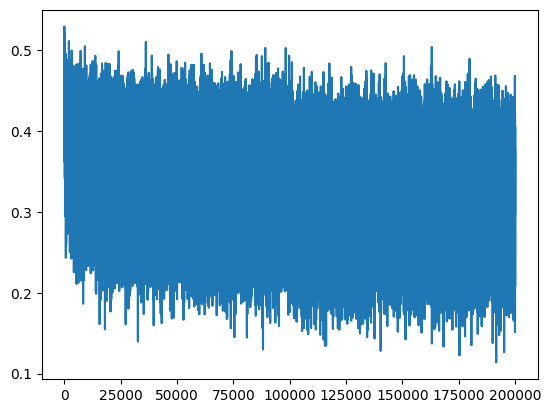

In [7]:
plt.plot(lossi)

In [10]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train' : {Xtr, Ytr},
    'val' : {Xdev, Ydev},
    'test' : {Xte, Yte},
  }[split]
  emb = C[x] # {N, block_size, n_emb}
  embcat = emb.view(emb.shape[0], -1) # concat itno (N, block_size * n_emb)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_run) / bnstd_run + bnbias # standardizing the hidden states, scale and shift
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(input=logits, target= y)
  print(split, loss.item())

split_loss('train')
split_loss('val')



train 2.061837673187256
val 2.102470636367798


### loss log

### original
train : 2.1445
val   : 2.1881

### fix softmax confidently wrong : squash w2 and b2 with (0.01, 0.0)
train : 2.07
val : 2.15

### fix tanh layer too saturated at init : squash w1 and b1 with (0.02, 0.0)
train : 2.0343
val : 2.118

### use semi-principled "kaiming init" instead of hacky init: by (* gain/sqrt(fan_in))
train : 2.0345
val : 2.168

### add a batch norm layer :  standardize the hidden states to roughly   gaussian
train : 2.05948
val : 2.1148

In [13]:
from math import log
# sample from the model
g = torch.Generator().manual_seed(2147483647+3)

for _ in range(10):

  out = []
  context = [0] * block_size # initialize with ...
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1, block_size, n_emb)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(input=probs, num_samples= 1, generator= g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print generated word




flismnnkmalineston.
bamkaysh.
sambrinb.
zhennyansbranciellaszividmugbgdulwynn.
fivfshmytta.
remalnyjeymastyte.
jenesestmelsidinjlahzidyn.
xhrduj.
surumaeberthn.
bal.


### ---- SUMMARY ----

In [81]:
# let's train a deeper network

class Linear:

  def __init__(self, fan_in, fan_out, bias = True) :
    self.weight = torch.randn((fan_in, fan_out), generator= g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)  # bn_gain
    self.beta = torch.zeros(dim)  # bn_bias
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(dim=0, keepdim=True)  # batch mean
      xvar = x.var(dim=0, keepdim=True)    # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_emb = 10  # dimensionlity of the char embedding vectors
n_hidden = 100 # no.of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator= g)
layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer:  make less confident
  # layers[-1].weight *= 0.1 # not required if using BatchNorm, we gamma
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer  in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


47551


In [82]:
# optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_data = []    # for how much amount of parameters data that we are updating

for i in range(max_steps):

  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]  # embed the characters into vectors
  x = emb.view(emb.shape[0], -1)  # concat the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(input=x, target=Yb)  # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()  # AFTER_DEBUG : would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())
  update_data.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:   # for debug
    break

      0/ 200000: 3.287031


Visualizing just weights of our layers flowing into tanh layers. doing with biases, gamma and beta is more complex.

notes:

*   mean should be very closer to zero or zero
*   std should be very closer 0.6, mostly towards 1
*   saturation (which is the amount of distribution at tails of tanh curve) should be closer to 2%-4%, higher is bad.



layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'weights activation distribution')

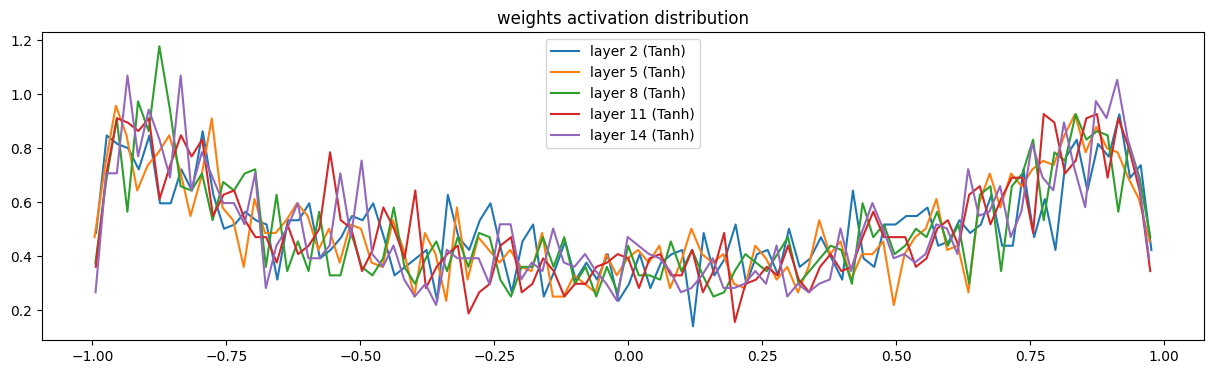

In [83]:
# visualize the weights histogram
plt.figure(figsize=(15, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('weights activation distribution')


layer 2 (      Tanh): mean -0.000000, std 3.682961e-03
layer 5 (      Tanh): mean -0.000000, std 3.262612e-03
layer 8 (      Tanh): mean +0.000000, std 2.973734e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584295e-03


Text(0.5, 1.0, 'gradient distribution')

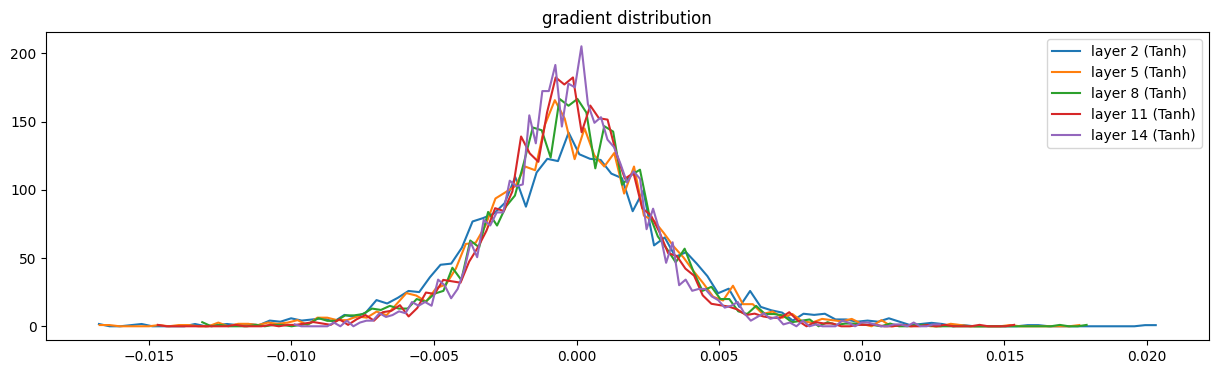

In [84]:
# visualize histograms
plt.figure(figsize=(15, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

### visualize weights and grad ratio of them
it gives us whats the ratio between the our grad and the parameters data that we are about to update.

higher ratio  tells us that we are updating very small small amount of the data, which is desirable.


weight   (27, 10) | mean +0.000000 | std 1.019890e-02 | grad:data ratio 1.018851e-02
weight  (30, 100) | mean +0.000092 | std 8.238448e-03 | grad:data ratio 2.635845e-02
weight (100, 100) | mean +0.000031 | std 7.318127e-03 | grad:data ratio 4.377153e-02
weight (100, 100) | mean -0.000019 | std 6.662029e-03 | grad:data ratio 3.949899e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ratio 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445303e-03 | grad:data ratio 3.243371e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281275e-02


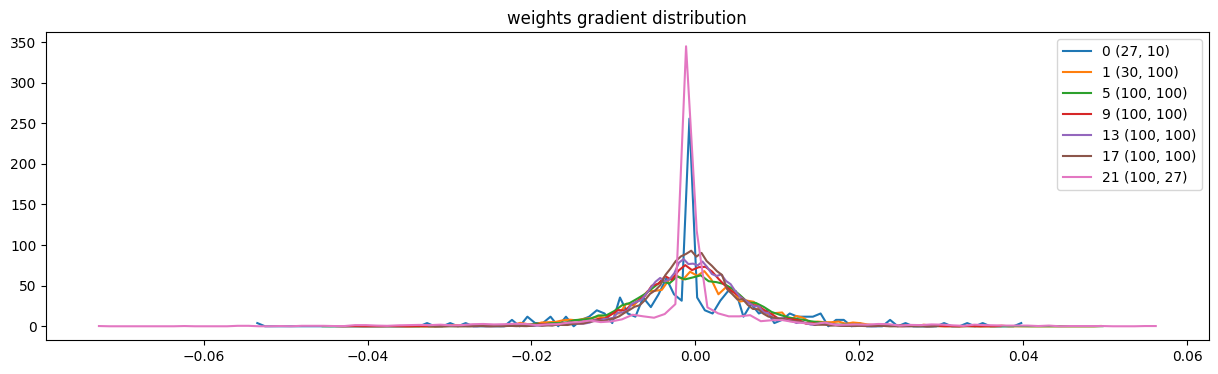

In [85]:
# visualize histograms
plt.figure(figsize=(15, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### Visualizing how much amount of data we are updating
closer to 1e-3 (which is -3) is very desirable

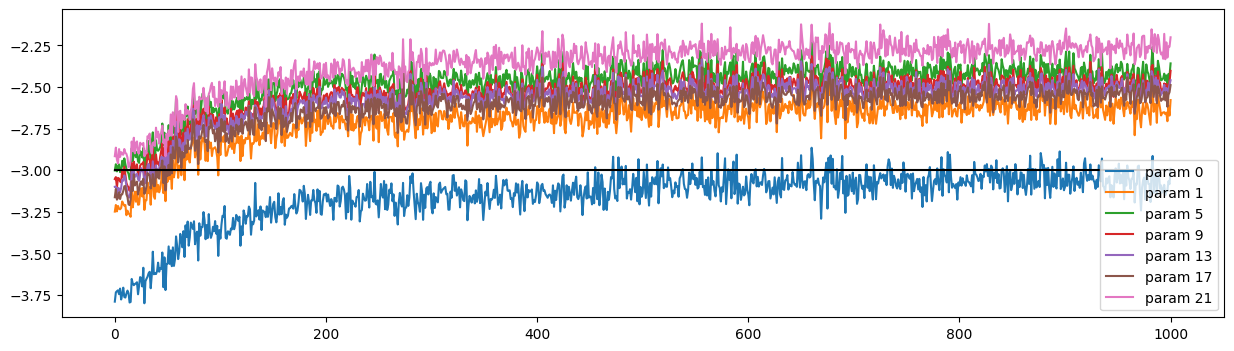

In [86]:
plt.figure(figsize=(15, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([update_data[j][i] for j in range(len(update_data))])
    legends.append('param %d' %i)
plt.plot([0, len(update_data)], [-3, -3], 'k')  # these should be close to 1e-3, indicate on plot
plt.legend(legends)

In [73]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.004842519760132
val 2.080256462097168


In [75]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 )

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

junide.
jakasir.
presayven.
makshir.
tolett.
juel.
kalania.
zamilena.
jadeyaire.
amel.
sejaicayla.
terinleem.
kyfodtum.
maryasleigh.
ani.
cora.
yae.
octay.
jamilyn.
kmois.
